In [13]:
from src.utils import utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import pdb
from collections import Counter
from seaborn import heatmap
from matplotlib.colors import LogNorm, Normalize
from src.utils.utils import categories


ModuleNotFoundError: No module named 'process_predictions_and_evaluate'

In [3]:
def convert_to_std_format(prediction_data):
    global causes_effects
    
    completion = prediction_data["completion"]
    completion = json.loads(completion)
    formatted = {"causes": [], "effects": []}
    flattened = []
    for narr, cats in completion.items():
        if cats == "":
            formatted[narr] = []
        else:
            fixed_cats = cats.replace("\"", "").split(",") 
            fixed_cats = [cat.strip() for cat in fixed_cats]
            formatted[narr] = fixed_cats
            flattened.extend(fixed_cats)
    prediction_data["prediction"] = formatted
    
    if len(flattened) == 0:
        flattened = ["none"]

    return prediction_data

In [4]:
data_path = f"/data/mourad/narratives/model_json_preds/proquest_basic/phi2_ft_test_sample_0"
prediction_data = utils.load_hf_dataset(path=data_path)
data_path = f"/data/mourad/narratives/model_json_preds/proquest_basic/phi2_ft_test_sample_0"
prediction_data = utils.load_hf_dataset(path=data_path)
prediction_data = prediction_data.map(convert_to_std_format)

/data/mourad/narratives/model_json_preds/proquest_basic/phi2_ft_test_sample_0_now


FileNotFoundError: Directory /data/mourad/narratives/model_json_preds/proquest_basic/phi2_ft_test_sample_0_now not found

In [5]:
pred_df = prediction_data.to_pandas()
pred_df['causes'] = pred_df['prediction'].apply(lambda x: list(x['causes']))
pred_df['effects'] = pred_df['prediction'].apply(lambda x: list(x['effects']))
pred_df['binary'] = pred_df.apply(lambda x: str(len(x.effects) > 0 or len(x.causes) > 0), axis=1)
pred_df['effects'] = pred_df.effects.apply(lambda x: x if x != [] else ["none"])
pred_df['causes'] = pred_df.causes.apply(lambda x: x if x != [] else ["none"])
pred_df = pred_df[['id', 'text', 'assigned','causes', 'effects', 'binary']]
pred_df

NameError: name 'prediction_data' is not defined

In [5]:
ds = utils.load_hf_dataset(path="/data/mourad/narratives/sft_data", dataset='proquest')

train_df = ds["train"].to_pandas()
# test_df = ds["test"].to_pandas()
mh_df = ds["test_mh"].to_pandas()
qz_df = ds["test_qz"].to_pandas()
az_df = ds["test_az"].to_pandas()
test_df = pd.concat([mh_df, qz_df, az_df])
pq_dfs = [("train", train_df), ("test", test_df), ("mh", mh_df), ("qz", qz_df), ("az", az_df)]

ds = utils.load_hf_dataset(path="/data/mourad/narratives/sft_data", dataset='now')
train_df = ds["train"].to_pandas()
# test_df = ds["test"].to_pandas()
mh_df = ds["test_mh"].to_pandas()
qz_df = ds["test_qz"].to_pandas()
az_df = ds["test_az"].to_pandas()
test_df = pd.concat([mh_df, qz_df, az_df])
now_dfs = [("train", train_df), ("test", test_df), ("mh", mh_df), ("qz", qz_df), ("az", az_df)]


/data/mourad/narratives/sft_data_proquest
/data/mourad/narratives/sft_data_now


In [6]:

def get_narrs(row):
    data = row.data.split("#")[-1]
    if data in ['true', 'false']:
        causes = ['none']
        effects = ['none']
    else:
        data = json.loads(data)
        causes, effects = [], []
        for d in data:
            if 'cause' in d:
                causes.append(d['cause'])
            if 'effect' in d:
                effects.append(d['effect'])
        
        if causes == []:
            causes = ['none']
        if effects == []:
            effects = ['none']
    return causes, effects

for name, df in now_dfs:
    df[['causes', 'effects']] = df.apply(get_narrs, result_type ='expand', axis=1)
    df['binary'] = df.apply(lambda x: str('none' not in x.effects or 'none' not in x.causes), axis=1)
    df.drop(['template', 'data'], inplace=True, axis=1)#[["id", "text", "assigned", "causes", "effects"]]
    
for name, df in pq_dfs:
    df[['causes', 'effects']] = df.apply(get_narrs, result_type ='expand', axis=1)
    df['binary'] = df.apply(lambda x: str('none' not in x.effects or 'none' not in x.causes), axis=1)
    df.drop(['template', 'data'], inplace=True, axis=1)#[["id", "text", "assigned", "causes", "effects"]]
        

In [7]:
def get_majority(causes):
    if not causes.dropna().empty:
        causes = Counter(causes.sum())
        causes = [c for c, v in causes.items() if v >= 2]
        # pdb.set_trace()
        # x['causes'] = causes
    # if not x.effects.dropna().empty:
    #     effects = Counter(x.effects.sum())
    #     effects = [c for c, v in effects.items() if v >= 2]
        # x['effects'] = effects
    return causes

# pq_tmp = pd.concat([all_dfs[0][1], all_dfs[1][1]], axis=0)
causes = pq_dfs[1][1].groupby('text').causes.apply(get_majority).to_frame()
effects = pq_dfs[1][1].groupby('text').effects.apply(get_majority).to_frame()
majority_df = pd.concat([causes, effects], axis=1).reset_index()

majority_df['binary'] = majority_df.apply(lambda x: str('none' not in x.effects or 'none' not in x.causes), axis=1)
majority_df['assigned'] = 'majority'
majority_df = pd.concat([pq_dfs[0][1], majority_df], axis=0)

majority_df['source'] = 'Historical' #'ProQuest'


def get_majority(causes):
    if not causes.dropna().empty:
        causes = Counter(causes.sum())
        causes = [c for c, v in causes.items() if v >= 2]
        # pdb.set_trace()
        # x['causes'] = causes
    # if not x.effects.dropna().empty:
    #     effects = Counter(x.effects.sum())
    #     effects = [c for c, v in effects.items() if v >= 2]
        # x['effects'] = effects
    return causes

# now_tmp = pd.concat([now_dfs[0][1], now_dfs[1][1]], axis=0)
causes = now_dfs[1][1].groupby('text').causes.apply(get_majority).to_frame()
effects = now_dfs[1][1].groupby('text').effects.apply(get_majority).to_frame()
now_majority_df = pd.concat([causes, effects], axis=1).reset_index()
now_majority_df['binary'] = now_majority_df.apply(lambda x: str('none' not in x.effects or 'none' not in x.causes), axis=1)
now_majority_df['assigned'] = 'majority'
now_majority_df = pd.concat([pq_dfs[0][1], now_majority_df], axis=0)

now_majority_df['source'] = 'Contemporary' #'NOW'

majority_df = pd.concat([now_majority_df, majority_df])

In [7]:
causes_df = majority_df[['text', 'causes', 'source']]
causes_df['kind'] = 'causes'
causes_df = causes_df.rename(columns={'causes': 'labels'})
causes_df = causes_df.explode('labels')
effects_df = majority_df[['text', 'effects', 'source']]
effects_df['kind'] = 'effects'
effects_df = effects_df.rename(columns={'effects': 'labels'})
effects_df = effects_df.explode('labels')
effects_df

both_df = pd.concat([causes_df, effects_df])
both_df.to_csv(f"/data/mourad/narratives/regression_data/gold_data_for_qz.csv")

/tmp/ipykernel_846029/1962841533.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  causes_df['kind'] = 'causes'
/tmp/ipykernel_846029/1962841533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effects_df['kind'] = 'effects'


In [12]:
data_df = majority_df.copy()
property = 'causes'
df = data_df.explode([property])
df = df.replace("none", None)
df = df.reset_index(drop=True)

df[property] = df[property].astype("category")
df[property] = df[property].cat.set_categories(categories[f"{property[:-1]}_category"])
df

,id,text,assigned,causes,effects,binary,source
0,61229.0,"And Alfred Kahn, tht head of President Carter'...",az,NaN,[none],False,Contemporary
1,61449.0,"On the contrary, when. as now, inflation is ou...",mh,NaN,[govt],True,Contemporary
2,61412.0,"""Most economists see the long-run connection b...",mh,NaN,[none],False,Contemporary
3,61249.0,Payment In Wine But inflation and recession en...,az,NaN,[none],False,Contemporary
4,61773.0,"""People aren't angry about inflation,"" inflati...",qz,NaN,[none],False,Contemporary
...,...,...,...,...,...,...,...
2722,NaN,Yet the patients in whose behalf the New Front...,majority,NaN,[none],False,Historical
2723,NaN,You'll find answers on page 35. 1973: A year o...,majority,NaN,[purchase],True,Historical
2724,NaN,firing line Monopolies Continued from page 13C...,majority,NaN,[none],False,Historical
2725,NaN,"inflation.""",majority,NaN,[none],False,Historical


/tmp/ipykernel_557649/1482586102.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.get_yticklabels()])


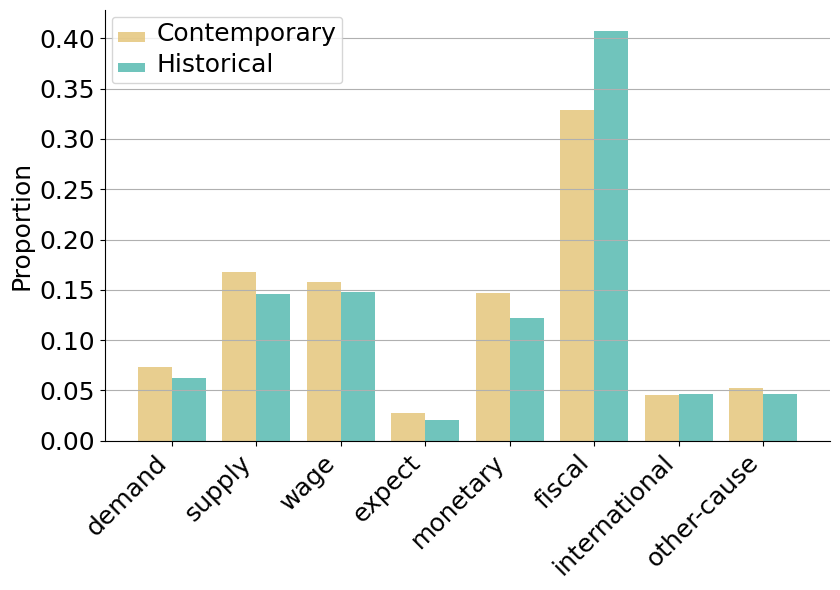

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_557649/1482586102.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.get_yticklabels()])


<Figure size 640x480 with 0 Axes>

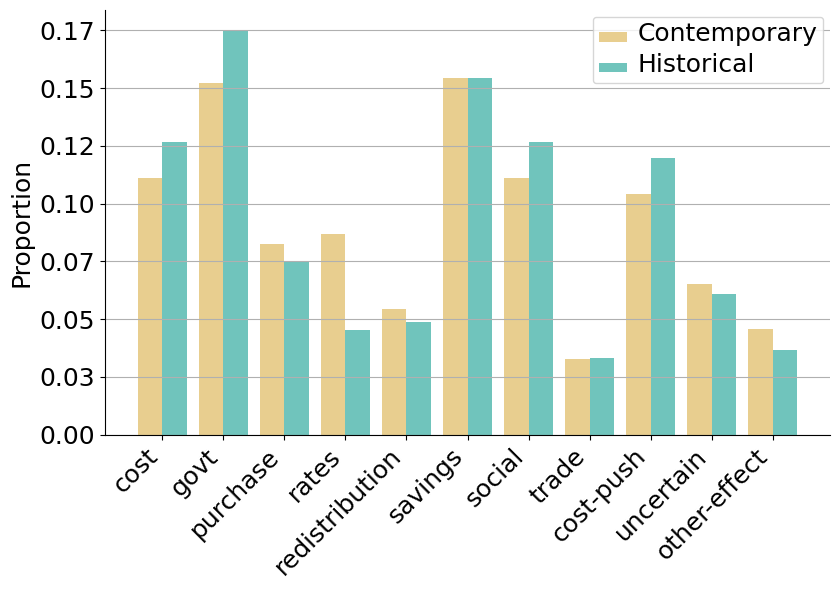

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
# data_df = pred_df.copy()
# data_df = test_df.copy()
fontsize = 18
data_df = majority_df.copy()
# pred_df.assigned = 'phi2'
# data_df = pd.concat([data_df, pred_df])
for property in ['causes', 'effects']: # binary
    plt.figure(figsize=(8.5, 6))
    df = data_df.explode([property])
    df = df.replace("none", None)
    df = df.reset_index(drop=True)
    df[property] = df[property].astype("category")
    df[property] = df[property].cat.set_categories(categories[f"{property[:-1]}_category"])

    # df=df.sort_values(by=property)
    # df.label = df.label.astype(str)
    # if data_type == "Metadata":
    #     df.label = df.apply(adjust_value_name, axis=1)
        # ax = sns.histplot(data=df, x="Property", stat='count', discrete=True)
    # Set custom colors for the plot
    colors = ['#E1BE6A', '#40B0A6']

    # Plot the histogram with custom colors
    ax = sns.histplot(data=df, x=property, stat='proportion', discrete=True, hue='source', multiple='dodge', shrink=.8, common_norm=False, edgecolor='none', palette=colors, binwidth=2)
    # ax = sns.histplot(data=df, x=property, stat='proportion', discrete=True, hue='source', multiple='dodge', shrink=.8, common_norm=False, edgecolor='none') #hue="Property"
    ax.yaxis.grid(True)  # Add horizontal grid lines
    # plt.yscale('log')
    # ax.legend(fontsize=fontsize)
    # plt.legend(fontsize=20)
    ax.get_legend().set_title("")
    plt.setp(plt.gca().get_legend().get_texts(), fontsize=fontsize)
    # plt.title(f"Inflation Narrative {property.capitalize()}")
    plt.title("")
    # ax.bar_label(ax.containers[1], label_type='edge', fmt='%.2f')
    plt.xlabel("")
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    ax.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.get_yticklabels()])

    
    # plt.xlabel("X Label", fontsize=14)
    plt.ylabel("Proportion", fontsize=fontsize)
    # set x labels to "Narrative" and "No narrative"
    if property == 'binary':
        ax.set_xticklabels(['Narrative', 'No Narrative'])
    else:

        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees
    
        
    ax.spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    plt.savefig(f"../../data/plots/proquest_plots/{property}_barplot.pdf", dpi=300)

    plt.show()
    ax.clear()
    plt.clf()
    
    plt.tight_layout()
    plt.savefig(f"../../data/plots/proquest_plots/{property}_barplot_indiv.pdf", dpi=300)

    plt.show()
    ax.clear()
    plt.clf()

502


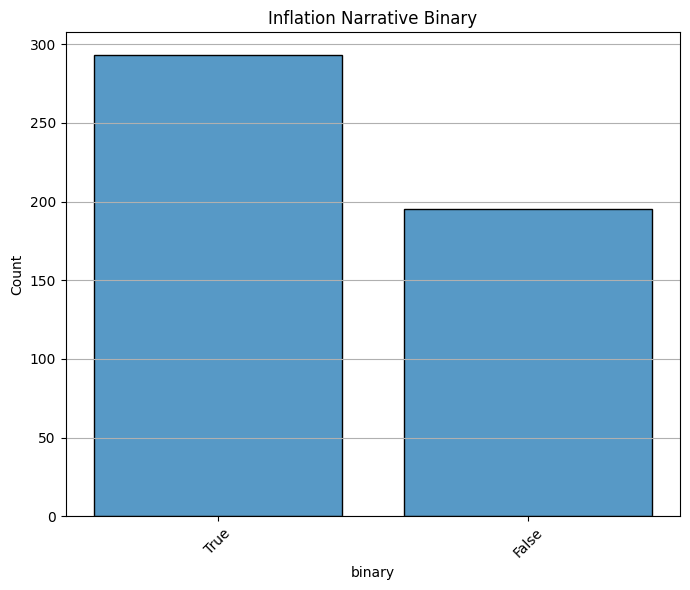

488


<Figure size 640x480 with 0 Axes>

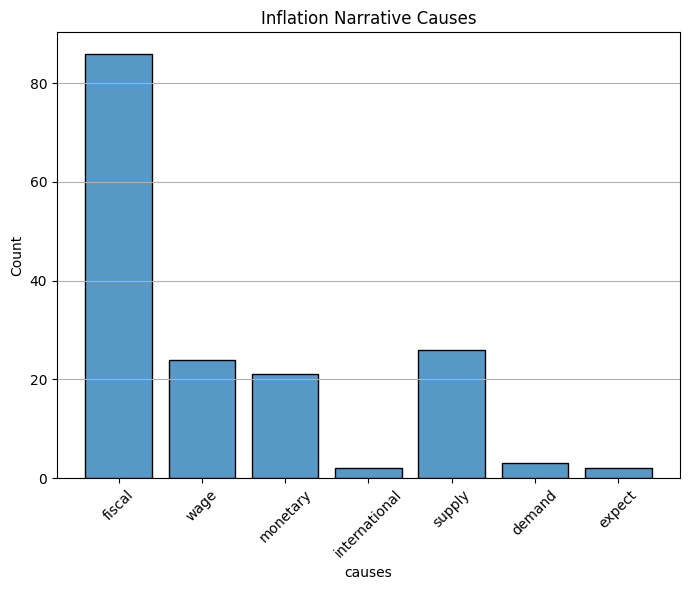

499


<Figure size 640x480 with 0 Axes>

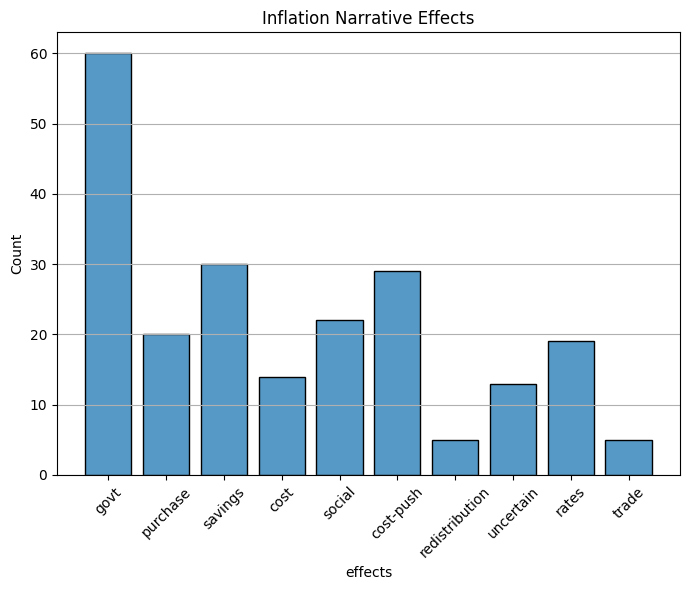

<Figure size 640x480 with 0 Axes>

In [18]:
for property in ['binary', 'causes', 'effects']:
    plt.figure(figsize=(7, 6))
    print(len(df[property].dropna()))
    df = pred_df.explode([property])
    df[property] = df[property].apply(lambda x: x.strip() if isinstance(x, str) else x)
   
    df = df.reset_index(drop=True)
    # df.label = df.label.astype(str)
    # if data_type == "Metadata":
    #     df.label = df.apply(adjust_value_name, axis=1)
        # ax = sns.histplot(data=df, x="Property", stat='count', discrete=True)
    ax = sns.histplot(data=df, x=property, stat='count', discrete=True, shrink=.8) #hue="Property"
    ax.yaxis.grid(True)  # Add horizontal grid lines
    # plt.title(f"{data_type}")
    plt.title(f"Inflation Narrative {property.capitalize()}")
    plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
    plt.tight_layout()
    plt.savefig(f"../../data/plots/proquest_plots/preds_{property}_barplot.png", dpi=300)

    plt.show()
    ax.clear()
    plt.clf()

In [18]:
az_df

,id,text,assigned,causes,effects,binary,cat
0,60015,They are superb guidelines and because of the ...,az*,[none],[none],False,"[none, none]"
1,59896,Inflation is eating into savings.but neither C...,az*,[none],[savings],True,"[none, savings]"
2,59809,Tight credit was supposed to cure inflation.,az*,[monetary],[none],True,"[monetary, none]"
3,59914,Republicans and Democrats will have much to sa...,az*,[fiscal],[none],True,"[fiscal, none]"
4,59567,"The move:d help offset the ""wide:~read impress...",az*,[none],[none],False,"[none, none]"
...,...,...,...,...,...,...,...
483,59763,"Do you think the White House has been ""telling...",az*,[none],[none],False,"[none, none]"
484,59757,Sam report.;. report.;.' a sin i II demonstrat...,az*,[none],[none],False,"[none, none]"
485,59586,Like 94 of the 100 biggest earners on a list p...,az*,[none],[none],False,"[none, none]"
486,59765,"The figure, described as preliminary, was subs...",az*,[none],[none],False,"[none, none]"


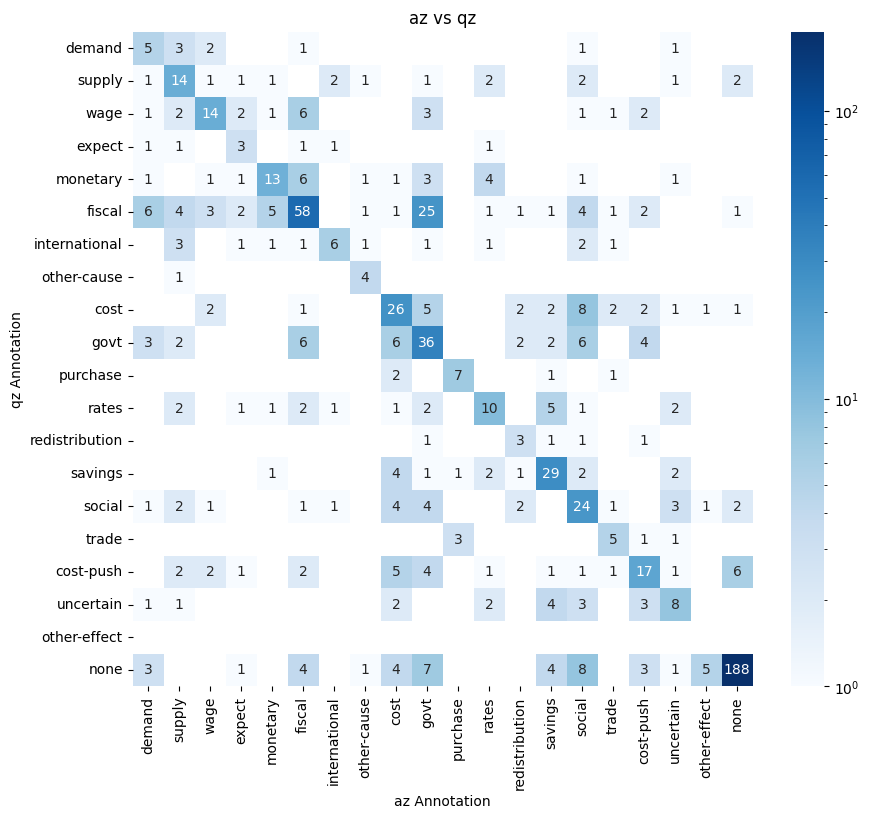

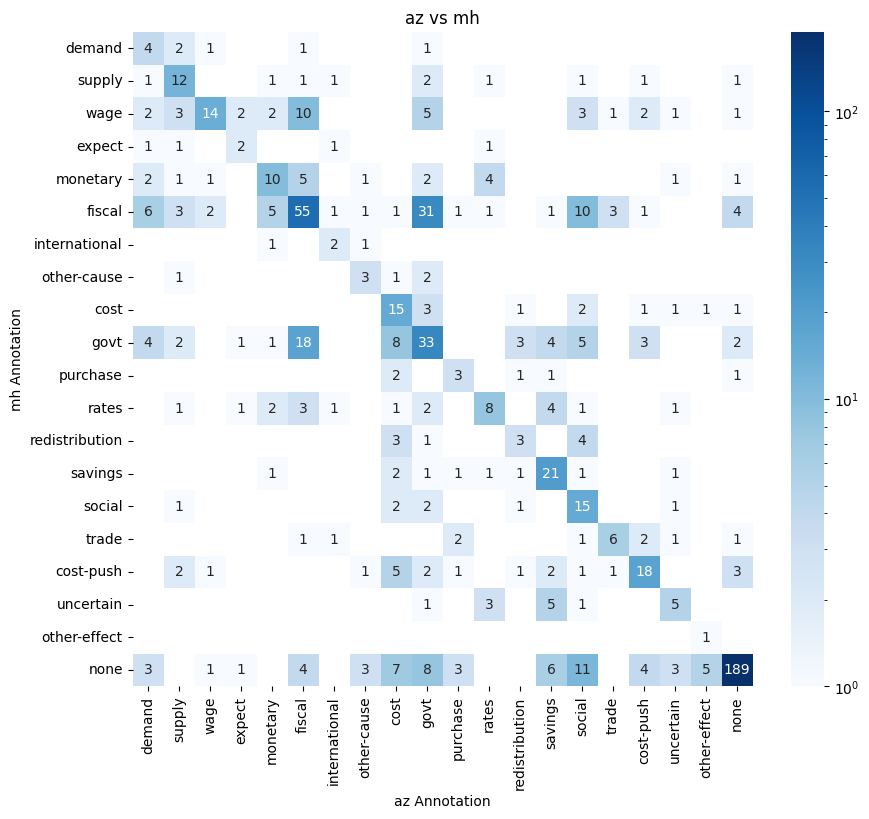

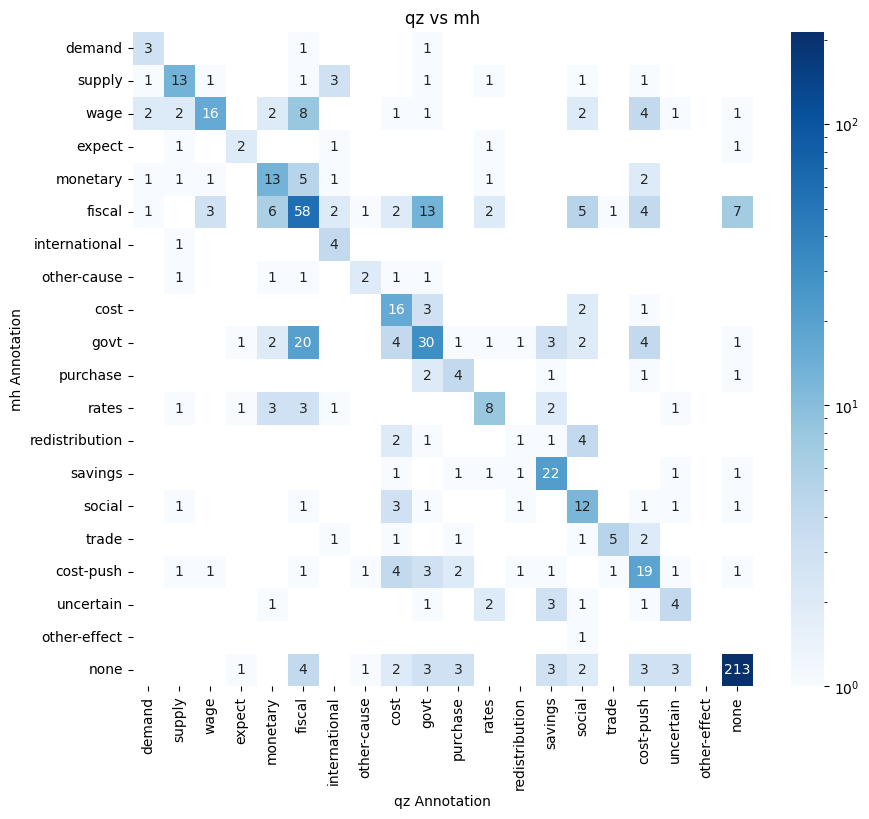

In [44]:

annotator_dfs = [('az', az_df.copy()), ('qz', qz_df.copy()), ('mh', mh_df.copy())]
for name, df in annotator_dfs:
    df['causes'] = df.causes.apply(lambda x: [] if x == ['none'] else x)
    df['effects'] = df.effects.apply(lambda x: [] if x == ['none'] else x)
    df['cat'] = df.apply(lambda x: list(set(x.causes + x.effects)), axis=1)
    df['cat'] = df.cat.apply(lambda x: ['none'] if x == [] else x)
    
types = categories['cause_effects']

for name, ann in annotator_dfs[:2]:
    # ann['cat'] = ann.apply(lambda x: list(set(x.causes + x.effects)), axis=1)
    for comp, ann2 in annotator_dfs[-2:]:
        # ann2['cat'] = ann2.apply(lambda x: list(set(x.causes + x.effects)), axis=1)
        if name != comp:
            df = pd.merge(ann, ann2, on='text', suffixes=('_'+name, '_'+comp))
            df = df[['cat_'+name, 'cat_'+comp]]
            df = df.explode(['cat_'+name])
            df = df.groupby('cat_'+name).agg(sum)
            # breakpoint()
            corresponding = df['cat_'+comp].apply(lambda x: Counter(x))
            
            heatmap_data = []
            for cat_pred in types:
                pred_row = []
                for cat_gold in types:
                    if cat_pred in corresponding:
                        pred_row.append(corresponding[cat_pred][cat_gold])
                    else:
                        pred_row.append(0)
                heatmap_data.append(pred_row)
            heatmap_data = np.array(heatmap_data).T
            # breakpoint()     
            
            fig, ax = plt.subplots(figsize=(10, 8.5))
            heatmap(heatmap_data, xticklabels=types, yticklabels=types, annot=True, norm=LogNorm(), cmap="Blues", fmt='g')
            plt.title(f"{name} vs {comp}")
            plt.xlabel(f"{name} Annotation")
            plt.ylabel(f"{comp} Annotation")
            plt.show()

In [47]:
mh_df.effects.apply(lambda x: 'cost' in x).sum()

16